In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy

# Estymacja Pi

## Metoda klasyczna

In [3]:
def estimate_pi(N):
    x = np.random.uniform(-1, 1, N)
    y = np.random.uniform(-1, 1, N)

    dist = np.sqrt(x**2 + y**2)
    inside = dist < 1

    return 4 * np.cumsum(inside) / np.arange(1, N + 1)

In [4]:
N = 100_000
print(f"Estimated area of the circle: {estimate_pi(N)[-1]:.4f}")

Estimated area of the circle: 3.1504


## Metoda z redukcją wariancji

wpisany kwadrat ma pole 2

In [7]:
def estimate_pi_variance_reduction(N):
    x = np.random.uniform(-1, -1 + (2 + np.sqrt(2))/2, N)
    y = np.random.uniform(1 - (2 - np.sqrt(2))/2, 1, N)

    dist = np.sqrt(x**2 + y**2)

    r = 1
    inside = dist < r

    area = 2 + 4 * np.cumsum(inside) / np.arange(1, N + 1) * (2 + np.sqrt(2))/2 * (2 - np.sqrt(2))/2
    return area

In [8]:
N = 100_000
print(f"Estimated area of the circle: {estimate_pi_variance_reduction(N)[-1]:.4f}")

Estimated area of the circle: 3.1441


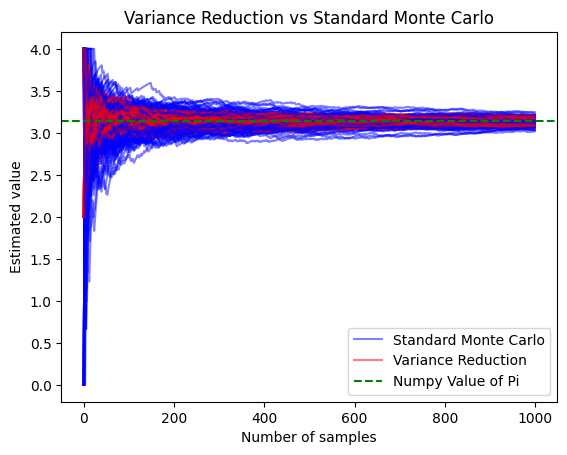

In [9]:
N = 1000
n = 100
for i in range(n):
    samples_pi = estimate_pi(N)
    samples_pi_variance_reduction = estimate_pi_variance_reduction(N)

    plt.plot(samples_pi, label='Standard Monte Carlo' if i == 0 else "", alpha=0.5, color='blue')
    plt.plot(samples_pi_variance_reduction, label='Variance Reduction' if i == 0 else "", alpha=0.5, color='red')

plt.axhline(y=np.pi, color='g', linestyle='--', label='Numpy Value of Pi')
plt.xlabel('Number of samples')
plt.ylabel('Estimated value')
plt.title('Variance Reduction vs Standard Monte Carlo')
plt.legend()
plt.show()

## Recursive stratified sampling

In [10]:
import numpy as np

def safe_variance(arr):
    if len(arr) == 0:
        return 0
    return np.var(arr)

def sample_recursive(x_bound, y_bound, N, min_budget, function):
    budget = int(0.05 * N)

    # base case
    if budget < min_budget:
        return np.array([]), np.array([])
    
    x_bottom, x_top = x_bound
    y_bottom, y_top = y_bound
    center_x = (x_bottom + x_top) / 2
    center_y = (y_bottom + y_top) / 2

    # Sample uniformly in this region
    x = np.random.uniform(x_bottom, x_top, budget)
    y = np.random.uniform(y_bottom, y_top, budget)

    # Subregions: (Q1: top-left, Q2: top-right, Q3: bottom-left, Q4: bottom-right)
    mask_1 = (x < center_x) & (y > center_y)
    mask_2 = (x >= center_x) & (y > center_y)
    mask_3 = (x < center_x) & (y <= center_y)
    mask_4 = (x >= center_x) & (y <= center_y)

    x_1, y_1 = x[mask_1], y[mask_1]
    x_2, y_2 = x[mask_2], y[mask_2]
    x_3, y_3 = x[mask_3], y[mask_3]
    x_4, y_4 = x[mask_4], y[mask_4]

    # tu jest nasza funkcja ukryta
    inside_1 = function(x_1, y_1)
    inside_2 = function(x_2, y_2)
    inside_3 = function(x_3, y_3)
    inside_4 = function(x_4, y_4)

    variance_1 = safe_variance(inside_1)
    variance_2 = safe_variance(inside_2)
    variance_3 = safe_variance(inside_3)
    variance_4 = safe_variance(inside_4)

    variances = [variance_1, variance_2, variance_3, variance_4]
    non_zero_variance = [v > 0 for v in variances]
    non_zero_variance_count = sum(non_zero_variance)

    # Sample recursively from subregions
    samples = []
    if variance_1 > 0:
        s_x, s_y = sample_recursive((x_bottom, center_x), (center_y, y_top), N / non_zero_variance_count, min_budget, function)
        samples.append((s_x, s_y))
    if variance_2 > 0:
        s_x, s_y = sample_recursive((center_x, x_top), (center_y, y_top), N / non_zero_variance_count, min_budget, function)
        samples.append((s_x, s_y))
    if variance_3 > 0:
        s_x, s_y = sample_recursive((x_bottom, center_x), (y_bottom, center_y), N / non_zero_variance_count, min_budget, function)
        samples.append((s_x, s_y))
    if variance_4 > 0:
        s_x, s_y = sample_recursive((center_x, x_top), (y_bottom, center_y), N / non_zero_variance_count, min_budget, function)
        samples.append((s_x, s_y))

    samples_x = [x]
    samples_y = [y]
    for sx, sy in samples:
        samples_x.append(sx)
        samples_y.append(sy)

    return np.concatenate(samples_x), np.concatenate(samples_y)

In [11]:
N = 1_000_000
min_budget = 10
x_bound = (-1, 1)
y_bound = (-1, 1)

def circle_indicator(x, y, r=1):
    return np.sqrt(x**2 + y**2) < r

x, y = sample_recursive(x_bound, y_bound, N, min_budget, circle_indicator)

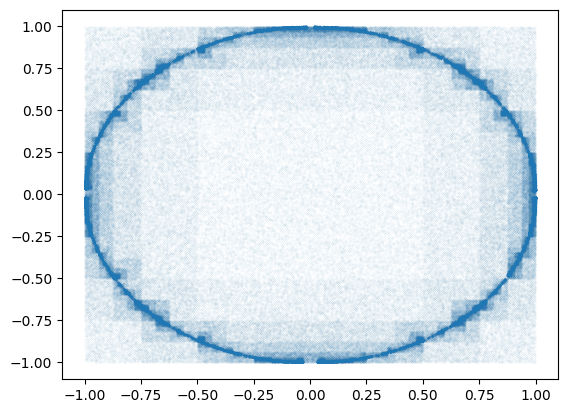

In [12]:
plt.plot(x, y, 'o', markersize=0.013)
plt.show()

### other functions

In [13]:
N = 1_000_000
min_budget = 10
x_bound = (-1, 1)
y_bound = (-1, 1)

def indicator_lemniscate(x, y):
    return (x**2 + y**2)**2 <= 2 * (x**2 - y**2)


x, y = sample_recursive(x_bound, y_bound, N, min_budget, indicator_lemniscate)


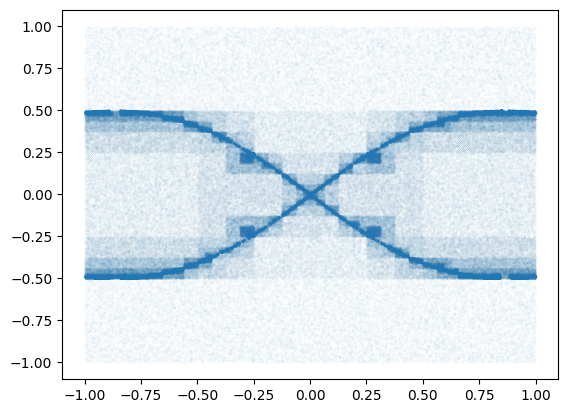

In [14]:
plt.plot(x, y, 'o', markersize=0.013)
plt.show()

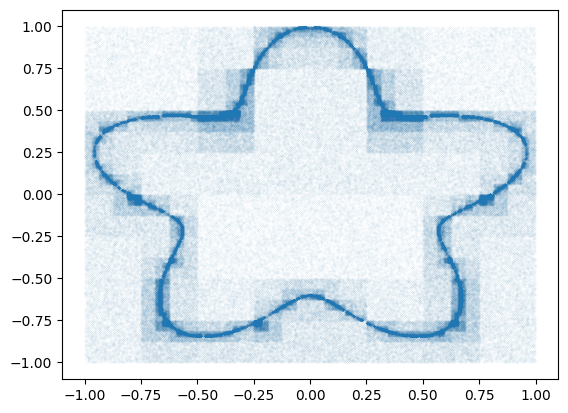

In [15]:
def indicator_star(x, y, arms=5):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r < 0.8 + 0.2 * np.sin(arms * theta)

x, y = sample_recursive(x_bound, y_bound, N, min_budget, indicator_star)
plt.plot(x, y, 'o', markersize=0.013)
plt.show()

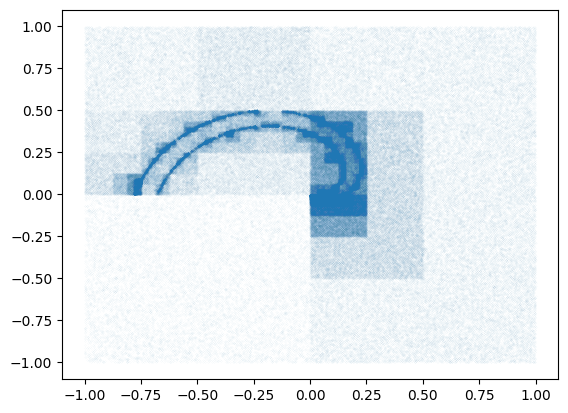

In [16]:
def indicator_spiral(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.abs(r - (0.1 + 0.2 * theta)) < 0.05

x, y = sample_recursive(x_bound, y_bound, N, min_budget, indicator_spiral)
plt.plot(x, y, 'o', markersize=0.013)
plt.show()

# Estymacja wartości całki

## A) Użycie klasycznego rozkładu Cauchy'ego

E[g(x)] = integral(g(x) * f(x)) dx

In [19]:
def estimate_integral_cauchy(n):
    x = np.random.standard_cauchy(size=n)
    selected_x = x[x > 10]

    while len(selected_x) < n:
        x = np.random.standard_cauchy(size=n)
        selected_x = np.concatenate((x[x > 10], selected_x))
    selected_x = selected_x[:n]

    vals = abs(np.sin(selected_x)) * np.pi

    integral_estimates = np.cumsum(vals) / np.arange(1, len(selected_x)+1)
    return integral_estimates

In [20]:
N = 100_000
print(f"Estimated value of integral: {estimate_integral_cauchy(N)[-1]:.4f}")

Estimated value of integral: 2.0635


## B) Importance sampling

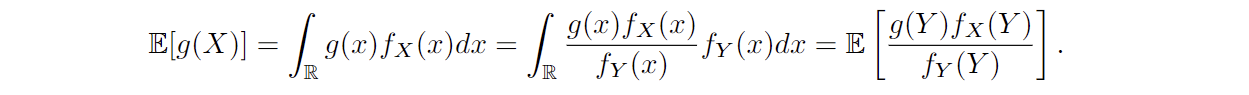

### cauchy

In [22]:
def estimate_integral_importance_cauchy(n):
    x = cauchy.rvs(size=n, loc=15, scale=1)
    selected_x = x[x > 10]
    while len(selected_x) < n:
        x = cauchy.rvs(size=n, loc=15, scale=1)
        selected_x = np.concatenate((x[x > 10], selected_x))
    selected_x = selected_x[:n]

    vals = abs(np.sin(selected_x)) * np.pi
    fy = 1 / (np.pi * (1 + (selected_x - 15)**2))
    fx = 1 / (np.pi * (1 + selected_x**2))

    integral_estimates = np.cumsum(vals * fx / fy) / np.arange(1, len(selected_x)+1)
    return integral_estimates

In [23]:
print(f"Estimated value of integral: {estimate_integral_importance_cauchy(N)[-1]:.4f}")    

Estimated value of integral: 0.0699


### Exp

In [25]:
def estimate_integral_importance_exp(n):
    lambda_ = 0.1
    x = 10 + np.random.exponential(scale=1/lambda_, size=n)
    selected_x = x

    g = abs(np.sin(selected_x)) * np.pi
    fy = lambda_ * np.exp(-lambda_ * (selected_x - 10))
    fx = 1 / (np.pi * (1 + selected_x**2))

    integral_estimates = np.cumsum(g * fx / fy) / np.arange(1, len(selected_x)+1)
    return integral_estimates

In [26]:
print(f"Estimated value of integral: {estimate_integral_importance_exp(N)[-1]:.4f}")

Estimated value of integral: 0.0607


## C)

In [ ]:
N = 100_000

samples = np.random.standard_cauchy(N)
samples = samples[samples > 10]

f = lambda x: np.abs(np.sin(x)) / (1 + x**2)
k = lambda x: 1 / (1 + x**2) # funkcja kontrolna

# Wartość oczekiwana funkcji k
expected_k = np.pi/2 - np.arctan(10)

f_vals = f(samples)
k_vals = k(samples)

estimator_cv = expected_k + np.mean(f_vals - k_vals)

print(f"Estymowana wartość całki (Control Variates): {estimator_cv:.6f}")

Estymowana wartość całki (Control Variates): 0.098682


In [28]:
def estimate_integral_control_variates(n):
    samples = np.random.standard_cauchy(n)
    samples = samples[samples > 10]
    while len(samples) < n:
        x = cauchy.rvs(size=n, loc=15, scale=1)
        samples = np.concatenate((x[x > 10], samples))
    samples = samples[:n]
    
    f = lambda x: np.abs(np.sin(x)) / (1 + x**2)
    k = lambda x: 1 / (1 + x**2) # funkcja kontrolna

    # Wartość oczekiwana funkcji k
    expected_k = np.pi/2 - np.arctan(10)

    f_vals = f(samples)
    k_vals = k(samples)

    estimator_cv = expected_k + np.cumsum(f_vals - k_vals) / np.arange(1, len(samples)+1)

    return estimator_cv

## D)

In [31]:
def estimate_integral_substitution(n):
    # podstawiamy x = 10/y, dx = -10/y^2 dy
    u = np.random.uniform(0, 1, n)
    vals = np.abs(np.sin(10/u)) * 10 / (u**2 + 100)
    integral_estimates = np.cumsum(vals) / np.arange(1, n+1)
    return integral_estimates

print(f"Estimated value of integral: {estimate_integral_substitution(N)[-1]:.4f}")    

Estimated value of integral: 0.0653


## Wizualizacja wyników

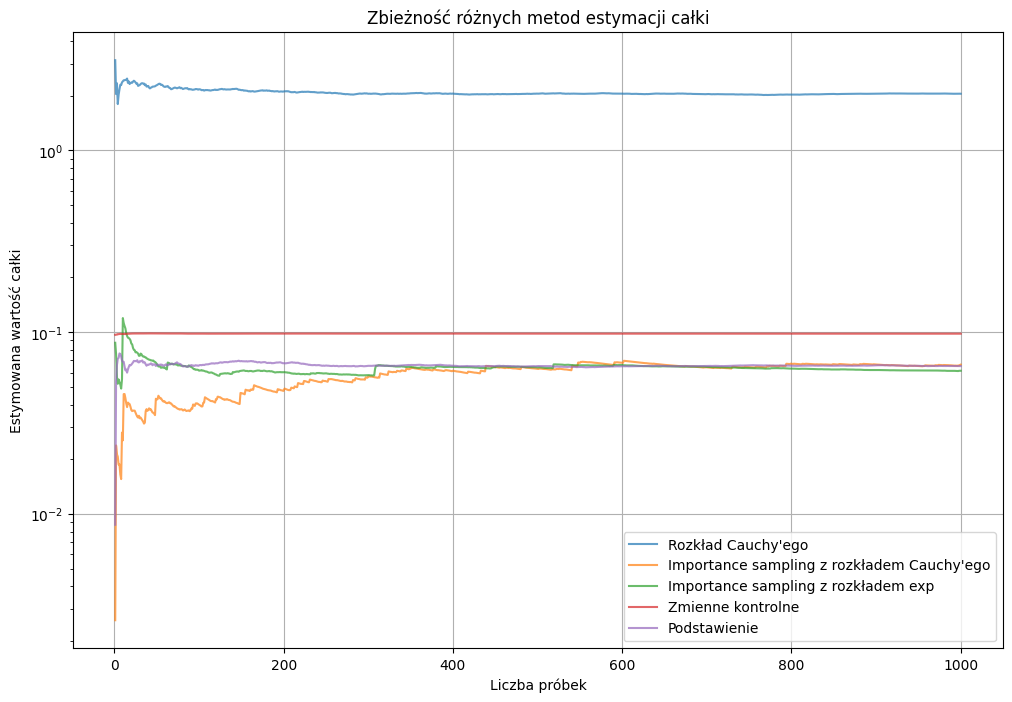

In [32]:
N = 1000

int_cauchy = estimate_integral_cauchy(N)
int_importance_cauchy = estimate_integral_importance_cauchy(N)
int_importance_exp = estimate_integral_importance_exp(N)
int_control = estimate_integral_control_variates(N)
int_substitution = estimate_integral_substitution(N)

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, N+1), int_cauchy, label='Rozkład Cauchy\'ego', alpha=0.7)
plt.plot(np.arange(1, N+1), int_importance_cauchy, label='Importance sampling z rozkładem Cauchy\'ego', alpha=0.7)
plt.plot(np.arange(1, N+1), int_importance_exp, label='Importance sampling z rozkładem exp', alpha=0.7)
plt.plot(np.arange(1, N+1), int_control, label='Zmienne kontrolne', alpha=0.7)
plt.plot(np.arange(1, N+1), int_substitution, label='Podstawienie', alpha=0.7)
plt.xlabel('Liczba próbek')
plt.ylabel('Estymowana wartość całki')
plt.title('Zbieżność różnych metod estymacji całki')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()